# Telco Customer Churn - EDA & Baseline Modeling


## Business Problem

Customer churn is costly: acquiring new customers often is more costly then retaining the existing ones. The goal of this project is to create a model that will **predict weather a Customer will churn or not** and to identify which factors are most associated with churn, so a business can prioritize retention actions.

## Objective
- Build ML model that predicts churn (binary classification).
- Evaluate model preformance using appropriate classification metrics (precision, recall, F1)
- Produce interpretable insights

## Approach

1. Load and validate data quality
2. clean and prepare features
3. EDA to understand churn patterns
4. Build a baseline ML model
5. Summarize Insights

## Dataset
Telco Customer Churn dataset from Kaggle. Each row represents a customer. Each column represents a customers attributes.

## 1. Imports

In [234]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Loading Data

We begin by loading the dataset and checking its basic structure.

In [235]:
dataPath = "../data/raw/archive/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(dataPath)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [236]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

Shape: (7043, 21)

Columns:
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


**Result:** The dataset contains 7043 customers and 21 columns, including demographics, service subscriptions, billing information, and the target variable churn.

## 3.  Data Quality Checks & Cleaning

- Column data types (numeric vs categorical)
- Missing values
- Potential type issues

This is required since ML models need consistent numeric formats.

In [237]:
print("\n--- INFO ---")
df.info()



--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

In [238]:
df.dtypes.value_counts()

object     18
int64       2
float64     1
Name: count, dtype: int64

In [239]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df.isna().sum().sort_values(ascending=False).head()


TotalCharges     11
gender            0
SeniorCitizen     0
Partner           0
customerID        0
dtype: int64

In [240]:
df = df.dropna(subset=["TotalCharges"])

df["churnNum"] = (df["Churn"] == "Yes").astype(int)

### 3.1 Fix TotalCharges Type

In this dataset, TotalCharges sometimes appears as a string (object dtype).
Some rows contain blanks which are not counted as NaN.
We convert Total Charges to numeric with 'errors="coerce"' to turn invalid values to NaN and then handle those missing rows.

**Decision:** Drop small number of rows with missing TotalCharges after conversion (11 rows)

## 4. Exploratory Data Analysis

We explore how churn differs across key customer attributes using:

- Summary Tables (Value counts, Crosstabs, pivot tables)
- Aggregations (groupby + agg)
- Visualizations (distributions and comparisons)


In [241]:
df["Churn"].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

In [242]:
(df["Churn"]
 .value_counts(normalize=True)  # proportions that sum to 1
 .mul(100)                      # convert to %
 .round(2))                     # rounding

Churn
No     73.42
Yes    26.58
Name: proportion, dtype: float64

### 4.1 Numeric Feature Summary

'describe()' summarizes numeric columns (count/mean/std/min/max and quartiles)

In [243]:
df.describe().round(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,churnNum
count,7032.00,7032.00,7032.00,7032.00,7032.00
mean,0.16,32.42,64.80,2283.30,0.27
std,0.37,24.55,30.09,2266.77,0.44
min,0.00,1.00,18.25,18.80,0.00
25%,0.00,9.00,35.59,401.45,0.00
50%,0.00,29.00,70.35,1397.48,0.00
75%,0.00,55.00,89.86,3794.74,1.00
max,1.00,72.00,118.75,8684.80,1.00


### Numeric Summary

- **Tenure** ranges from new customers to long-long term customers, churn is often higher among low tenure customers, so tenure is likely an important attribute.
- **MonthlyCharges** shows meaningful spread, suggested customers likely have very differenc plans.
- **TotalCharges** is cumulative billing and tends to increase with tenure; low totals often correspond with customers with very short tenure.

### 4.2 Churn rate by Contract

We compute churn rates by Contract to understand how churn differs across contract length.

In [244]:
pd.crosstab(df["Contract"], df["Churn"], normalize="index").sort_values("Yes", ascending=False)

Churn,No,Yes
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887228,0.112772
Two year,0.971513,0.028487


### Churn rate by contract

- Month-to-month customers churn at a much higher rate than customers on 1-year or 2-year contract.
- Longer contracts are associated with significantly lower churn, suggesting **contract type** is a strong churn driver.
- This points to targeting and converting Month-to-month customers with incentives to move to longer-term plans.

### 4.3 Churn rates for other categorical features

After checking Contract, we examine other categorical features to see which groups have higher churn risk.
Instead of raw counts, we compute **churn rate** (The proportion of customers with 'Churn = Yes')

Rather than choosing features randomly, we start with business-plausible churn drivers:
- **Commitment** (Contract)
- **Service experience** (InternetService)
- **Billing friction** (PaymentMethod)

In [245]:
categorical_to_check = ["InternetService", "PaymentMethod"]


for col in categorical_to_check:

    rates = (df.groupby(col))["churnNum"].mean().sort_values(ascending=False)

    print(f"\nChurn rate by {col}:\n")
    display(rates.round(3))


Churn rate by InternetService:



InternetService
Fiber optic    0.419
DSL            0.190
No             0.074
Name: churnNum, dtype: float64


Churn rate by PaymentMethod:



PaymentMethod
Electronic check             0.453
Mailed check                 0.192
Bank transfer (automatic)    0.167
Credit card (automatic)      0.153
Name: churnNum, dtype: float64

**Key Observations:**

- **InternetService:** Customers with **Fiber optic** have the highest churn rate ~41.9%, followed by **DSL** ~19.0%. Customers with **no internet service** have the lowest churn rate ~7.4%
-**PaymentMethod:** **Electronic Check** has the highest churn rate ~45.3%, substantially higher than the other payment methods ~15-19%.

These gaps suggest InternetService and PaymentMethod are likely strong predictors of churn and represent actionable segments. Reduce reliance on electronic check by encouraging autopay.

### 4.4 Interaction Check

Single-variable churn rates can be helpful, but churn risk can depend on feature combinations.
We use a pivot table to inspect churn rates across Contract x InternetService segments and identify potential hot spots.

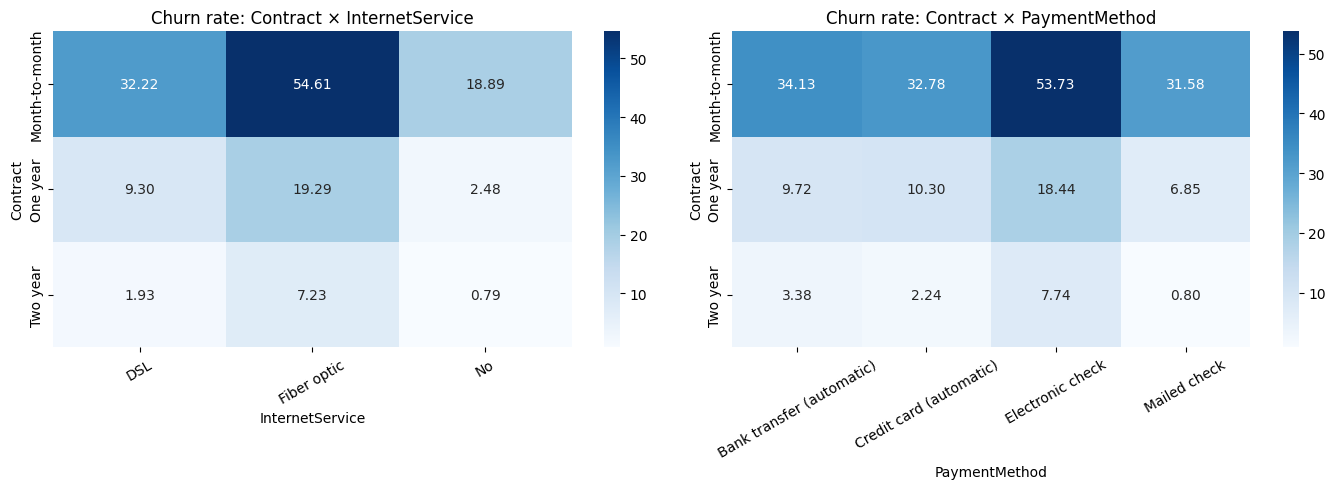

In [246]:
pivot_ratesC = df.pivot_table(

    index = "Contract",
    columns="InternetService",
    values="churnNum",
    aggfunc="mean"
)

pivot_ratesP = df.pivot_table(

    index = "Contract",
    columns="PaymentMethod",
    values="churnNum",
    aggfunc="mean"
)

fix, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.heatmap((pivot_ratesC * 100).round(2), annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("Churn rate: Contract × InternetService")
axes[0].set_xlabel("InternetService")
axes[0].set_ylabel("Contract")
axes[0].tick_params(axis="x", labelrotation=30)

sns.heatmap((pivot_ratesP * 100).round(2), annot=True, fmt=".2f", cmap="Blues", ax=axes[1])
axes[1].set_title("Churn rate: Contract × PaymentMethod")
axes[1].set_xlabel("PaymentMethod")
axes[1].set_ylabel("Contract")
axes[1].tick_params(axis="x", labelrotation=30)

plt.tight_layout()
plt.show()

**Key Observations:**

**Contract x InternetService**
- The highest churn segment is Month-to-Month + Fiber optic.
- Churn decreases sharply as contract length increases across all internet types.
- Fiber optic customers have higher churn than DSL and no-internet customers.

**Contract x PaymentMethod**
- **Electronic check** has the highest churn rate within every contract type.
- **Automatic payment methods** (bank transfer / credit card) are consistently lower churn than electronic check, especially for longer contracts.
- Contract length still dominates overall churn reduction, but payment method adds additional separation even after controlling for contract.

### 4.5 Churn spread across attributes

For each categorical feature, we compute churn rates per category and report the difference between maximum and minimum churn categories.
A larger spread suggests the feature provides stronger separation between churned vs retained customer and may be more predictive.

In [248]:
cat_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

summary = []

for col in cat_cols:
    rates = df.groupby(col)["churnNum"].mean()
    summary.append({
        "feature": col,
        "min_churn": rates.min(),
        "max_churn": rates.max(),
        "spread": rates.max() - rates.min()
    })
    

cat_spread = (pd.DataFrame(summary)
              .sort_values("spread", ascending=False))

cat_spread.head(10)

,feature,min_churn,max_churn,spread
13,Contract,0.028487,0.427097,0.398610
6,InternetService,0.074342,0.418928,0.344586
7,OnlineSecurity,0.074342,0.417787,0.343445
10,TechSupport,0.074342,0.416475,0.342133
8,OnlineBackup,0.074342,0.399417,0.325075
9,DeviceProtection,0.074342,0.391403,0.317061
15,PaymentMethod,0.152531,0.452854,0.300323
12,StreamingMovies,0.074342,0.337289,0.262947
11,StreamingTV,0.074342,0.335351,0.261009
1,SeniorCitizen,0.236503,0.416813,0.180310


**Key Observations:**
- The strongest churn separation comes from **Contract**, confirming contract length is a major churn driver.
- Several **service add-ons** (OnlineSecurity, TechSupport, OnlineBackup, DeviceProtection) rank high, suggesting customers value features strongly relate to churn.

### 4.6 Top service add-ons vs churn

Based on the categorical screening, we check the highest-ranked service add-ons.

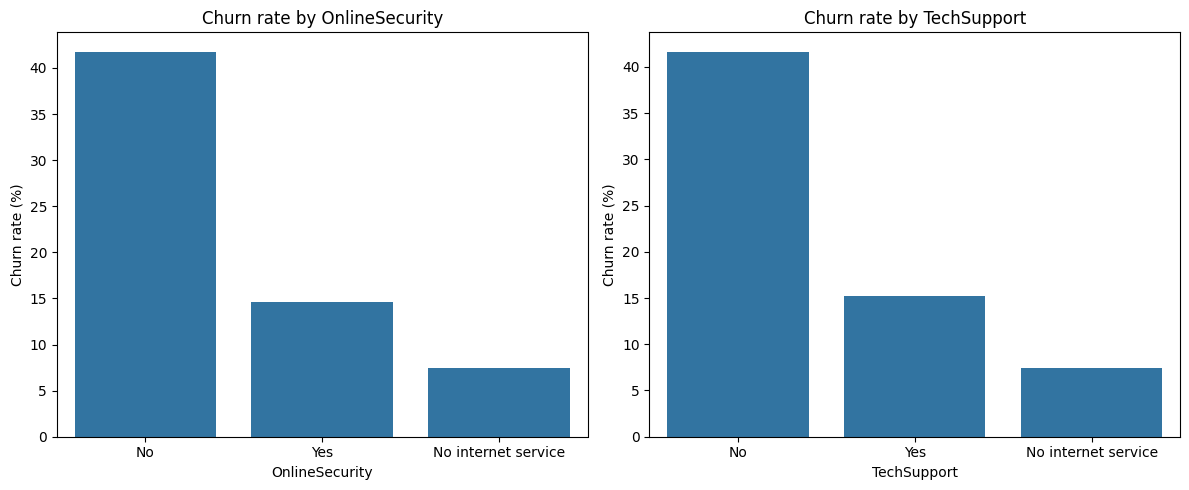

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col in zip(axes,["OnlineSecurity", "TechSupport"]):
    rates = df.groupby(col)["churnNum"].mean().sort_values(ascending=False) * 100
    sns.barplot(x=rates.index, y=rates.values, ax=ax)
    ax.set_title(f"Churn rate by {col}")
    ax.set_ylabel("Churn rate (%)")
    ax.set_xlabel(col)


plt.tight_layout()
plt.show()


**Key Observations:**
- Customers with **no OnlineSecurity / no TechSupport** have the highest churn ~42%, suggesting these add-ons are strongly asscociated with retention.
- The **No internet service** group has the lowest churn ~7-8%. This segment is  structurally different.